In [1]:
import os
import torch
import numpy as np
import pandas as pd

import scanpy as sc
from anndata import AnnData
import anndata as ad

result_dir = "../edges/"
raw_type=False
use_edge=False
normalize=True

In [2]:
import matplotlib.pyplot as plt
# Set global font sizes using rcParams
plt.rcParams.update({
    'font.size': 18,            # Global font size
    'axes.titlesize': 20,       # Font size of the axes title
    'axes.labelsize': 20,       # Font size of the x and y labels
    'xtick.labelsize': 16,      # Font size of the x-tick labels
    'ytick.labelsize': 16,      # Font size of the y-tick labels
    'legend.fontsize': 18,      # Font size of the legend
    'figure.titlesize': 24      # Font size of the figure title
})

In [3]:
samples=['sample1_rep1', 'sample1_rep2']
sample='sample1_rep1'#samples[7]
data_dir = "../../data/BC/processed1/"
str_position_x='centerx'
str_position_y='centery'
str_cell_type='subclass'
cell_types=['B_Cells', 'CD4+_T_Cells', 'CD8+_T_Cells', 'DCIS_1', 'DCIS_2', 'Endothelial', 'IRF7+_DCs', 'Invasive_Tumor', 'LAMP3+_DCs', 'Macrophages_1', 'Macrophages_2', 'Mast_Cells', 'Myoepi_ACTA2+', 'Myoepi_KRT15+', 'Perivascular-Like', 'Prolif_Invasive_Tumor', 'Stromal', 'Stromal_&_T_Cell_Hybrid', 'T_Cell_&_Tumor_Hybrid', 'Unlabeled']
cell_types=cell_types[:-1]
print(cell_types)

genes = torch.load("/".join(data_dir.split("/")[:-2]) + "/genes.pth")
print("GFAP" in genes,genes)
type_exp_dict=np.load(data_dir + sample + "_TypeExp.npz", allow_pickle=True)

cell_type_pair_sequence=[]
for cell_typei in cell_types:
    for cell_typej in cell_types:
        cell_type_pair_sequence.append(cell_typei+"->"+cell_typej)

feature_names=[]
for i in range(len(cell_types)):
    for j in range(len(genes)):
        feature_names.append(cell_types[i]+"--"+genes[j])

['B_Cells', 'CD4+_T_Cells', 'CD8+_T_Cells', 'DCIS_1', 'DCIS_2', 'Endothelial', 'IRF7+_DCs', 'Invasive_Tumor', 'LAMP3+_DCs', 'Macrophages_1', 'Macrophages_2', 'Mast_Cells', 'Myoepi_ACTA2+', 'Myoepi_KRT15+', 'Perivascular-Like', 'Prolif_Invasive_Tumor', 'Stromal', 'Stromal_&_T_Cell_Hybrid', 'T_Cell_&_Tumor_Hybrid']
False ['ABCC11', 'ACTA2', 'ACTG2', 'ADAM9', 'ADGRE5', 'ADH1B', 'ADIPOQ', 'AGR3', 'AHSP', 'AIF1', 'AKR1C1', 'AKR1C3', 'ALDH1A3', 'ANGPT2', 'ANKRD28', 'ANKRD29', 'ANKRD30A', 'APOBEC3A', 'APOBEC3B', 'APOC1', 'AQP1', 'AQP3', 'AR', 'AVPR1A', 'BACE2', 'BANK1', 'BASP1', 'BTNL9', 'C15orf48', 'C1QA', 'C1QC', 'C2orf42', 'C5orf46', 'C6orf132', 'CAV1', 'CAVIN2', 'CCDC6', 'CCDC80', 'CCL20', 'CCL5', 'CCL8', 'CCND1', 'CCPG1', 'CCR7', 'CD14', 'CD163', 'CD19', 'CD1C', 'CD247', 'CD27', 'CD274', 'CD3D', 'CD3E', 'CD3G', 'CD4', 'CD68', 'CD69', 'CD79A', 'CD79B', 'CD80', 'CD83', 'CD86', 'CD8A', 'CD8B', 'CD9', 'CD93', 'CDC42EP1', 'CDH1', 'CEACAM6', 'CEACAM8', 'CENPF', 'CLCA2', 'CLDN4', 'CLDN5', 'CLEC

In [4]:
print('SPP1' in genes)

False


In [5]:
def aggregate_interation_strength(sample,select_hvg=False):
    results=torch.load(result_dir+"edges_"+sample+".pth",map_location=torch.device('cpu'))

    position_x=results["position_x"][:,0]
    position_y=results["position_y"][:,0]
    cell_type_name=np.array(results["cell_type_name"])
    cell_type_target=cell_type_name[:,0]

    type_exps=torch.stack([torch.Tensor(type_exp_dict[cell_type_targeti]) for cell_type_targeti in cell_type_target],dim=0)
    results["y"]=results["y"]+type_exps
    
    attention_scores=results["attention_score"]
    cell_type_names = np.array(results["cell_type_name"])

    proportion=torch.abs(attention_scores)
    proportion=proportion/torch.sum(proportion,dim=1,keepdim=True)
    attention_scores[proportion<0.035]=0#0.035
    
    # Initialize a tensor to hold aggregated interaction strengths
    B, _, C = attention_scores.shape
    t = len(cell_types)
    aggregated_interactions = torch.zeros((B, t, C))
    
    # Map cell type names to indices
    cell_type_to_index = {ct: idx for idx, ct in enumerate(cell_types)}
    
    # Aggregate interaction strengths by cell type
    for b in range(B):
        for n in range(1, 50):  # Skip the first element, which is the target cell type
            neighbor_type = cell_type_names[b][n]
            if neighbor_type in cell_type_to_index:
                idx = cell_type_to_index[neighbor_type]
                aggregated_interactions[b, idx] += attention_scores[b, n-1]
    
    if normalize:
        aggregated_interactions1=aggregated_interactions/torch.sum(torch.abs(aggregated_interactions),dim=1,keepdim=True)
        aggregated_interactions=torch.where(torch.sum(torch.abs(aggregated_interactions),dim=1,keepdim=True)==0,torch.zeros_like(aggregated_interactions),aggregated_interactions1)

    adata = AnnData(aggregated_interactions.reshape(B,-1).numpy())
    adata.obs['cell_type'] = cell_type_target
    adata.obs['Spatial x']=position_x
    adata.obs['Spatial y']=position_y
    adata.var_names=feature_names
    adata.obsm["y"]=results["y"].numpy()

    
    if select_hvg:
        # Quality control
        sc.pp.filter_cells(adata, min_genes=200)
        sc.pp.filter_genes(adata, min_cells=3)
        # Identify highly variable genes
        sc.pp.highly_variable_genes(adata, min_mean=0, max_mean=1, min_disp=0,n_top_genes=2000)
        adata = adata[:, adata.var.highly_variable]
    print(adata.shape)
    return adata

adata=aggregate_interation_strength(sample)
print(adata,np.min(adata.X))

(159224, 6099)
AnnData object with n_obs × n_vars = 159224 × 6099
    obs: 'cell_type', 'Spatial x', 'Spatial y'
    obsm: 'y' -1.0


In [6]:
#adata=sc.read_h5ad("../cluster/aggregated/"+sample+".h5ad")
#print(np.min(adata.X))

In [7]:
#adata.X=np.abs(adata.X)

In [8]:
import matplotlib.pyplot as plt

def plot_cell_type(adata, fig_width=8, fig_height=6):
    with plt.rc_context({'figure.figsize': (fig_width, fig_height)}):
        sc.tl.pca(adata, n_comps=50)
        sc.pp.neighbors(adata)  # Compute the neighborhood graph
        sc.tl.umap(adata)  # Compute UMAP
        sc.pl.umap(adata, color='cell_type')

#plot_cell_type(adata, fig_width=6, fig_height=5)

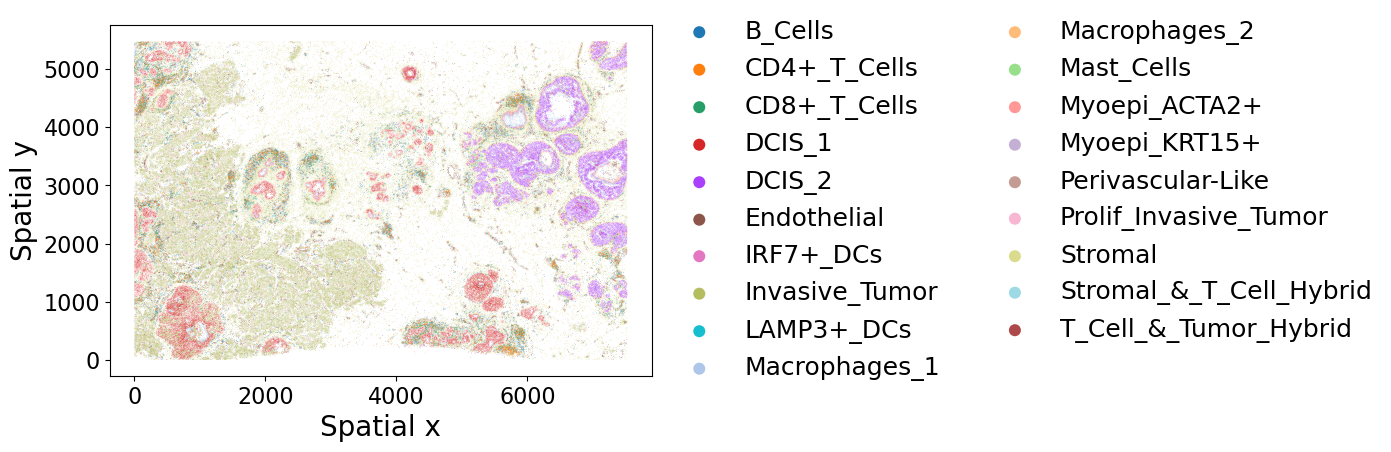

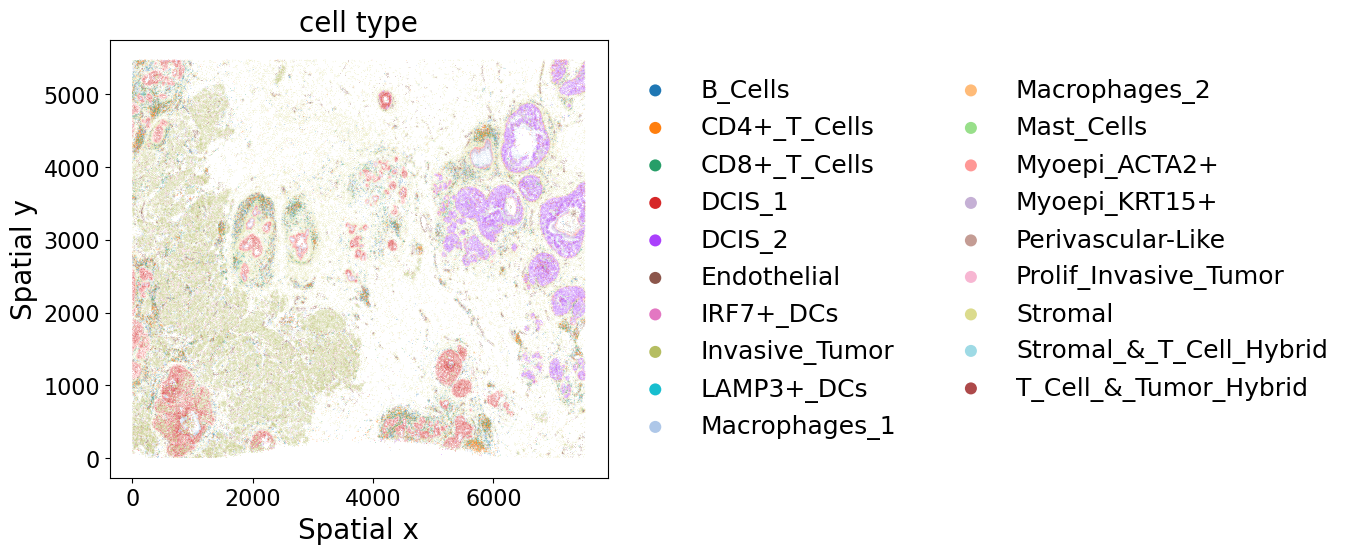

In [9]:
sc.pl.scatter(
        adata,
        x='Spatial x',#'Spatial x',
        y='Spatial y',#'Spatial y',
        color="cell_type",title="",save="SP.pdf"
    )

with plt.rc_context({'figure.figsize': (6,6)}):
    sc.pl.scatter(
        adata,
        x='Spatial x',#'Spatial x',
        y='Spatial y',#'Spatial y',
        color="cell_type"
    )

In [10]:
#plot_cell_type(ad.AnnData(X=np.abs(adata.obsm["y"]), obs=adata.obs), fig_width=6, fig_height=5)

In [11]:
print(cell_types)

['B_Cells', 'CD4+_T_Cells', 'CD8+_T_Cells', 'DCIS_1', 'DCIS_2', 'Endothelial', 'IRF7+_DCs', 'Invasive_Tumor', 'LAMP3+_DCs', 'Macrophages_1', 'Macrophages_2', 'Mast_Cells', 'Myoepi_ACTA2+', 'Myoepi_KRT15+', 'Perivascular-Like', 'Prolif_Invasive_Tumor', 'Stromal', 'Stromal_&_T_Cell_Hybrid', 'T_Cell_&_Tumor_Hybrid']


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


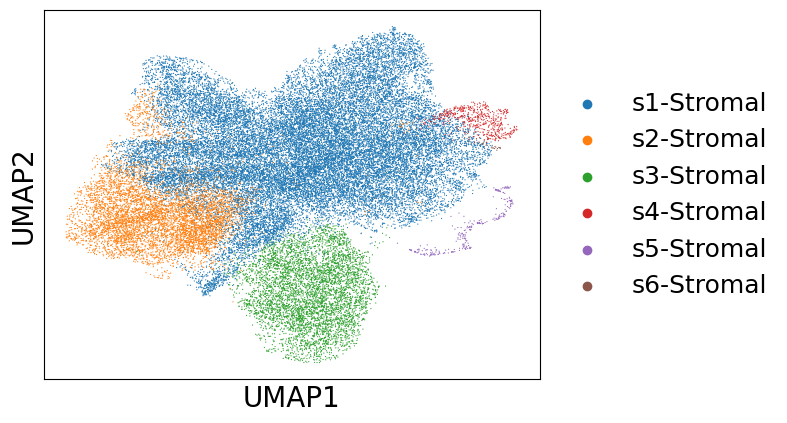

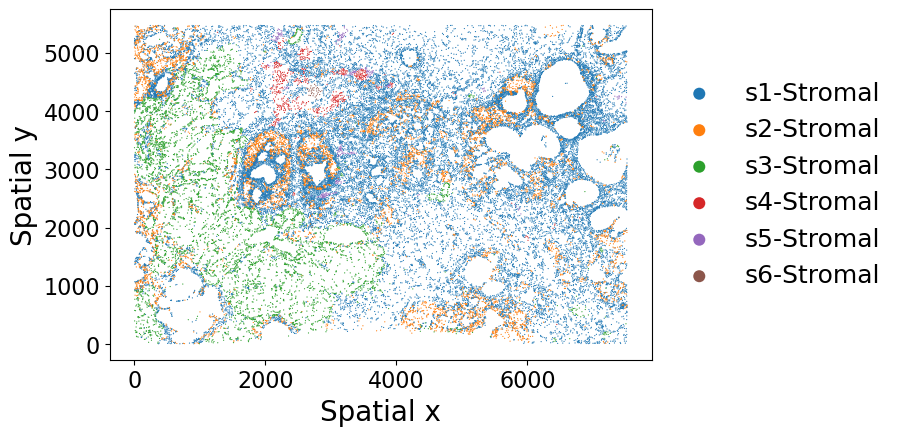

In [37]:
def plot(adata1,type_to_plot="Astrocyte",select=6,resolution=0.1):
    adata=adata1[adata1.obs["cell_type"]==type_to_plot]
    
    sc.tl.pca(adata, n_comps=50)
    sc.pp.neighbors(adata)  # Compute the neighborhood graph
    
    # Clustering
    sc.tl.leiden(adata,resolution=resolution)  # or sc.tl.louvain(adata)
    adata.obs["leiden"]=["s"+str(int(i)+1)+"-"+COI for i in adata.obs["leiden"].values]
    
    # Plot UMAP
    sc.tl.umap(adata)  # Compute UMAP
    sc.pl.umap(adata, color='leiden',title="",save=COI.replace("/","-")+"-umap.pdf")

    sc.pl.scatter(
        adata,
        x='Spatial x',#'Spatial x',
        y='Spatial y',#'Spatial y',
        color="leiden",
        title="",
        save=COI.replace("/","-")+"-sp.pdf"
    )
    return adata

COI='Stromal'#'Macrophages_1'#'DCIS_2'#'B_Cells'#'Stromal'
resolution=0.14#0.2#0.14
adata_type=plot(adata,type_to_plot=COI,resolution=resolution)

# 'B_Cells', yes, 0.2
# 'DCIS_1' 0.08
# 'DCIS_2' 0.16
# 'Macrophages_1' 0.18
# 'CD8+_T_Cells' 0.08
# 'Endothelial' 0.14
# 'Stromal' 0.14
# 'Myoepi_ACTA2+' 0.14

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


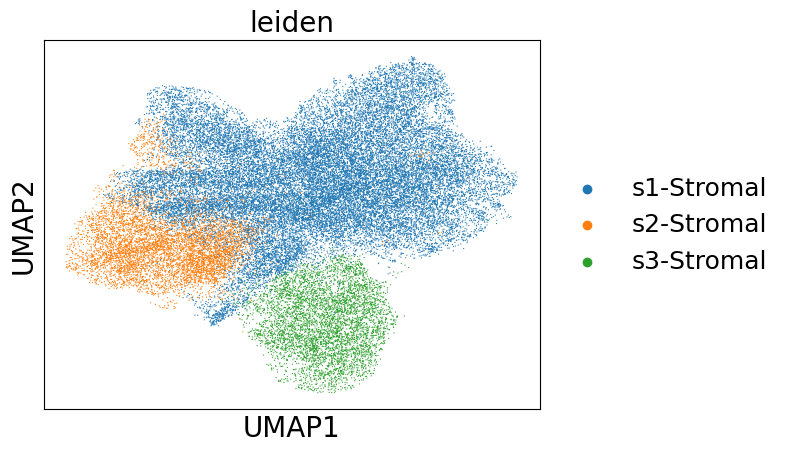

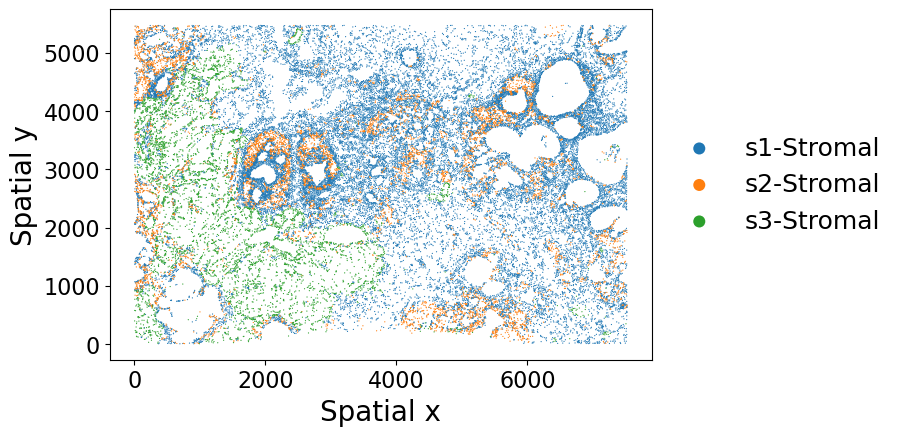

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


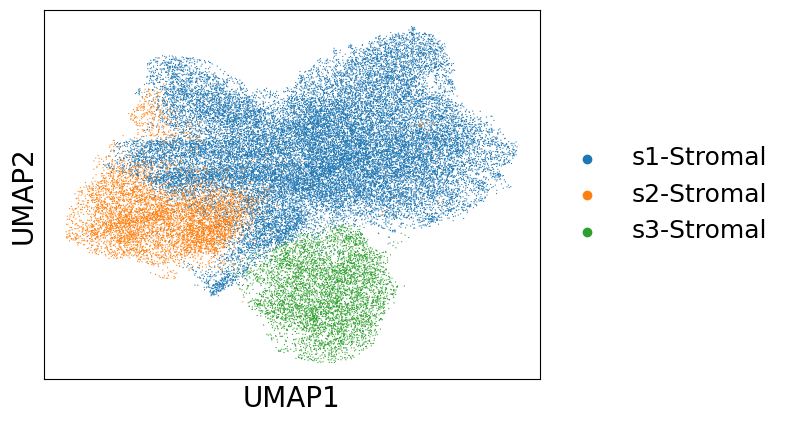

In [38]:
if COI=='Stromal' or COI=='DCIS_2':
    flag=[adata_type.obs['leiden'][i][1] in ['3','1','2'] for i in range(adata_type.shape[0])]
    adata_type=adata_type[flag]
    sc.pl.umap(adata_type, color='leiden')
    sc.pl.scatter(
        adata_type,
        x='Spatial x',#'Spatial x',
        y='Spatial y',#'Spatial y',
        color="leiden",
        title="",
        save=COI.replace("/","-")+"-sp.pdf"
    )
    sc.pl.umap(adata_type, color='leiden',title="",save=COI.replace("/","-")+"-umap.pdf")


         Falling back to preprocessing with `sc.pp.pca` and default params.


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


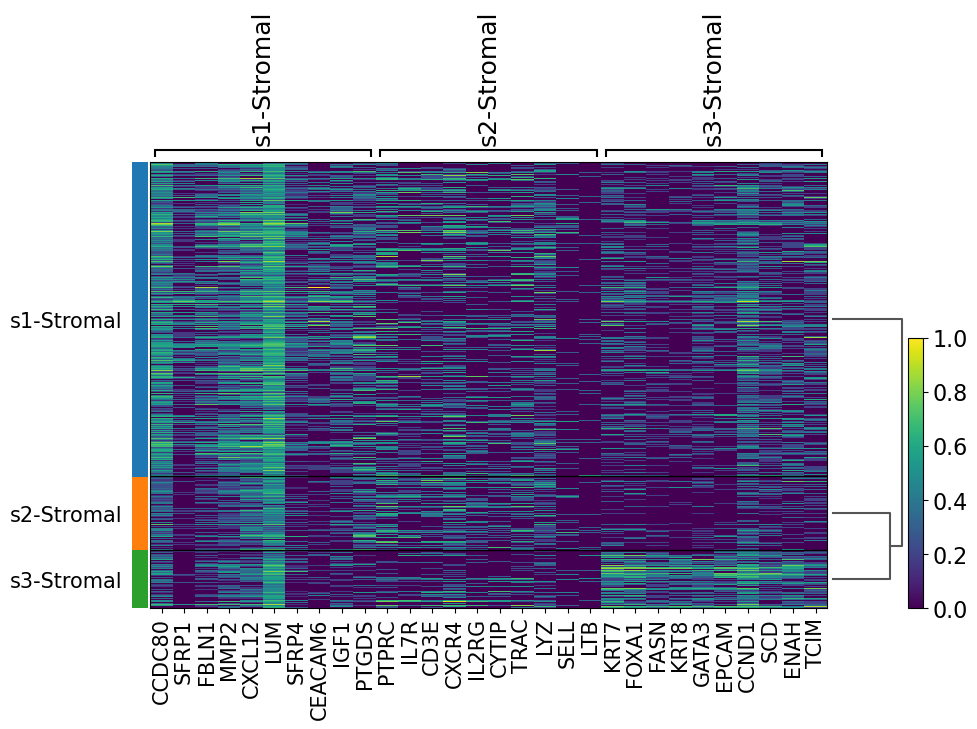

Group s1-Stromal:
Gene: CCDC80, Adjusted p-value: 0.0
Gene: SFRP1, Adjusted p-value: 0.0
Gene: FBLN1, Adjusted p-value: 0.0
Gene: MMP2, Adjusted p-value: 0.0
Gene: CXCL12, Adjusted p-value: 0.0
Gene: LUM, Adjusted p-value: 0.0
Gene: SFRP4, Adjusted p-value: 0.0

Group s2-Stromal:
Gene: PTPRC, Adjusted p-value: 8.195289188113151e-60
Gene: IL7R, Adjusted p-value: 5.082124468344346e-51
Gene: CD3E, Adjusted p-value: 9.419429198773798e-45
Gene: CXCR4, Adjusted p-value: 2.0122197481710268e-42
Gene: IL2RG, Adjusted p-value: 2.3979657378868938e-33
Gene: CYTIP, Adjusted p-value: 1.4588386000565406e-32
Gene: TRAC, Adjusted p-value: 5.896721535154753e-30

Group s3-Stromal:
Gene: KRT7, Adjusted p-value: 0.0
Gene: FOXA1, Adjusted p-value: 0.0
Gene: FASN, Adjusted p-value: 0.0
Gene: KRT8, Adjusted p-value: 0.0
Gene: GATA3, Adjusted p-value: 0.0
Gene: EPCAM, Adjusted p-value: 0.0
Gene: CCND1, Adjusted p-value: 0.0



In [39]:
select=10
adata_y=ad.AnnData(X=np.abs(adata_type.obsm["y"]), obs=adata_type.obs)
#adata_y=adata_y[adata_y.obs['leiden'].isin(["0","1"])]#,"2","2","3"
adata_y.var_names=genes
sc.tl.rank_genes_groups(adata_y, 'leiden', method='wilcoxon')#sc.tl.rank_genes_groups(adata_type_attention, 'group', method='t-test')
# Generate the heatmap without displaying it immediately
sc.pl.rank_genes_groups_heatmap(adata_y, 
                                n_genes=select, 
                                show_gene_labels=True, 
                                standard_scale='var', 
                                cmap='viridis', 
                                show=False)
# Access all axes in the current figure
axes = plt.gcf().get_axes()
# Loop through each axis and remove the y-axis label
for ax in axes:
    ax.set_ylabel('')
# Show the plot
plt.show()

def print_adjusted_pvals(adata, n_genes=7):
    # Perform differential expression analysis
    sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
    
    # Extract the results from rank_genes_groups
    results = adata.uns['rank_genes_groups']
    
    # Get the groups
    groups = results['names'].dtype.names
    
    # Iterate through each group and get the top n_genes
    for group in groups:
        print(f"Group {group}:")
        
        # Get the top n_genes and their corresponding adjusted p-values
        gene_names = results['names'][group][:n_genes]
        pvals_adj = results['pvals_adj'][group][:n_genes]
        
        # Print the results
        for gene, pval_adj in zip(gene_names, pvals_adj):
            print(f"Gene: {gene}, Adjusted p-value: {pval_adj}")
        print()

print_adjusted_pvals(adata_y)

In [49]:
def extract_genes_and_pvals_by_group(adata, group_index, cutoff=0.05, up=True, name=None):
    # Extracting gene names and p-values from the adata object
    gene_names = adata.uns['rank_genes_groups']['names']
    p_values = adata.uns['rank_genes_groups']['pvals']
    logfoldchanges=adata.uns['rank_genes_groups']['logfoldchanges']
    p_adj=adata.uns['rank_genes_groups']['pvals_adj']
    
    # Lists to hold filtered gene names and their corresponding p-values
    filtered_genes = []
    filtered_pvals = []
    
    # Iterate through each group in the gene names and p-values
    for gene_group, pval_group,fold_group in zip(gene_names, p_adj, logfoldchanges):
        gene = gene_group[group_index]
        pval = pval_group[group_index]
        foldchange=fold_group[group_index]
        
        # Check if p-value is below the cutoff and add to the lists if it is
        #print(pval,foldchange)
        if pval < cutoff and ((foldchange>0)==up):
            filtered_genes.append(gene)
            filtered_pvals.append(pval)
    
    return filtered_genes, filtered_pvals

         Falling back to preprocessing with `sc.pp.pca` and default params.


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


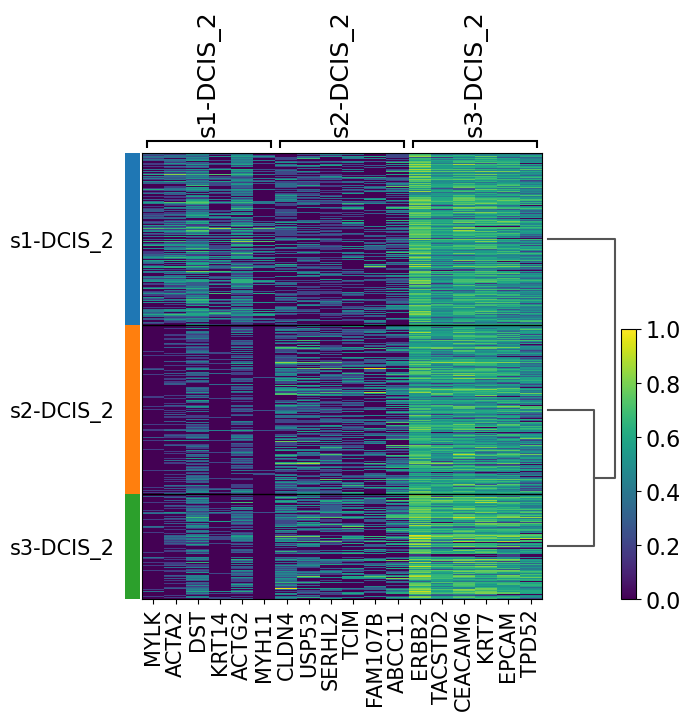

(['CLDN4', 'USP53', 'SERHL2', 'TCIM', 'FAM107B', 'ABCC11', 'AQP3'], [1.48470105348859e-22, 1.4744358274811118e-13, 1.922388762712879e-09, 1.9392347034993918e-06, 5.9215798539392564e-05, 0.018422821481431935, 0.021287471264001313])
(['PGR', 'FOXC2', 'ERN1', 'CRISPLD2', 'TCF4', 'RTKN2', 'AKR1C1', 'CD93', 'CCL5', 'KIT', 'HOOK2', 'THAP2', 'FSTL3', 'MNDA', 'CDC42EP1', 'PIM1', 'IGF1', 'C1QA', 'HAVCR2', 'CD8A', 'MAP3K8', 'VWF', 'APOC1', 'ZEB1', 'SDC4', 'SLC25A37', 'TRAC', 'FCGR3A', 'FBLN1', 'TOP2A', 'PECAM1', 'PRDM1', 'PTGDS', 'TACSTD2', 'ANKRD28', 'PCLAF', 'BASP1', 'SFRP4', 'OCIAD2', 'DMKN', 'PTPRC', 'OPRPN', 'ADGRE5', 'LPXN', 'KLF5', 'VOPP1', 'CXCR4', 'TRIB1', 'IGSF6', 'PELI1', 'PDGFRB', 'EIF4EBP1', 'CEACAM8', 'ALDH1A3', 'TCF7', 'CD4', 'CD68', 'CENPF', 'TFAP2A', 'TIFA', 'FGL2', 'KARS', 'DNTTIP1', 'ANKRD30A', 'C6orf132', 'MKI67', 'CXCL16', 'C1QC', 'TUBB2B', 'SH3YL1', 'LYZ', 'ZEB2', 'FOXA1', 'MMP2', 'AIF1', 'HDC', 'ADAM9', 'SMAP2', 'CCDC80', 'SRPK1', 'PDK4', 'PTRHD1', 'OXTR', 'ITM2C', 'FBLIM1

In [50]:
select=6
adata_y=ad.AnnData(X=np.abs(adata_type.obsm["y"]), obs=adata_type.obs)
#adata_y=adata_y[adata_y.obs['leiden'].isin(["0","1"])]#,"2","2","3"
adata_y.var_names=genes
sc.tl.rank_genes_groups(adata_y, 'leiden', method='wilcoxon')#sc.tl.rank_genes_groups(adata_type_attention, 'group', method='t-test')

# Generate the heatmap without displaying it immediately
sc.pl.rank_genes_groups_heatmap(adata_y, 
                                n_genes=select, 
                                show_gene_labels=True, 
                                standard_scale='var', 
                                cmap='viridis', 
                                show=False)
# Access all axes in the current figure
axes = plt.gcf().get_axes()
# Loop through each axis and remove the y-axis label
for ax in axes:
    ax.set_ylabel('')
# Show the plot
plt.savefig("./figures/"+COI.replace("/","-")+"-DE.pdf", bbox_inches='tight')
plt.show()

print(extract_genes_and_pvals_by_group(adata_y,1,0.05,True))
print(extract_genes_and_pvals_by_group(adata_y,1,0.05,False))

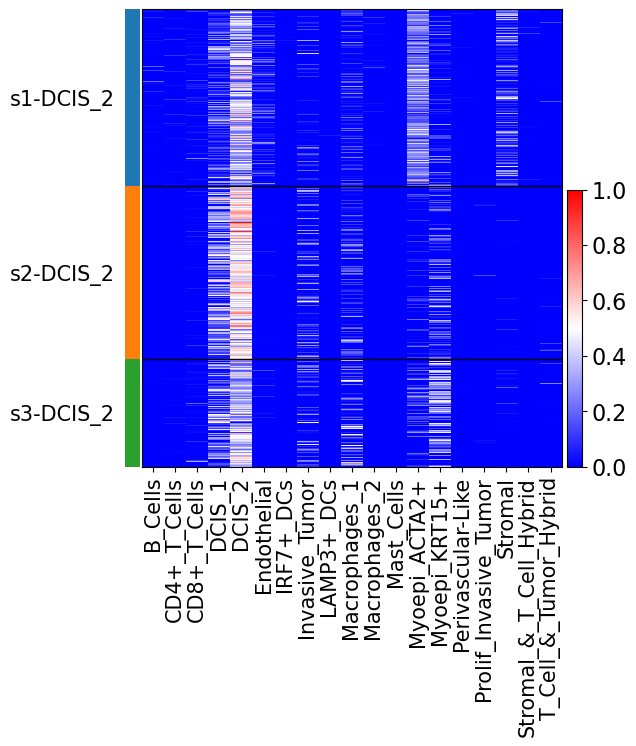

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


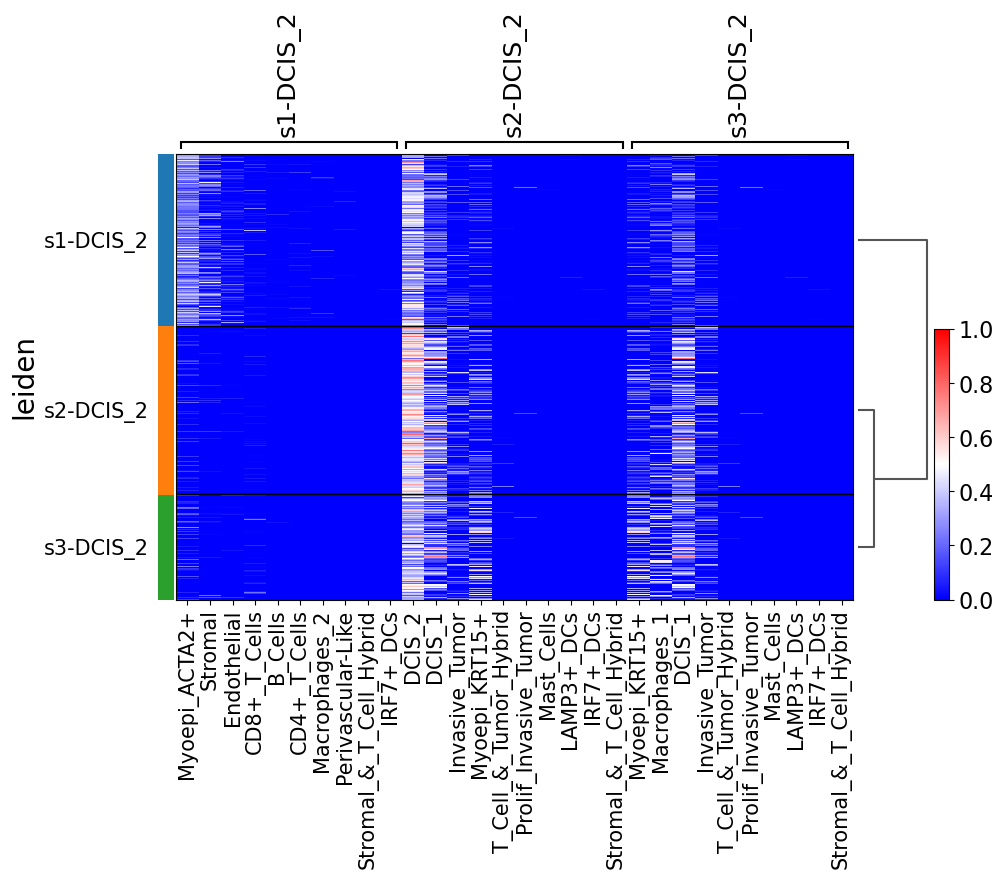

(['DCIS_2', 'DCIS_1', 'Invasive_Tumor'], [0.0, 1.4067990444074704e-209, 1.9474555162511597e-65])
(['Myoepi_KRT15+', 'Stromal_&_T_Cell_Hybrid', 'Perivascular-Like', 'Macrophages_1', 'Macrophages_2', 'CD4+_T_Cells', 'B_Cells', 'CD8+_T_Cells', 'Endothelial', 'Stromal', 'Myoepi_ACTA2+'], [1.6701409012700423e-05, 0.002973622853595073, 0.0012721477543626827, 3.2504558126589563e-06, 6.538518983565414e-09, 4.77842085302179e-18, 4.233144880939341e-20, 1.5878101254087115e-87, 0.0, 0.0, 0.0])


In [51]:
def aggregate_all_genes(adata):
    x=np.zeros((adata.shape[0],len(cell_types)))
    for i in range(len(cell_types)):
        offset=i*len(genes)
        x[:,i]=np.mean(np.abs(adata.X[:,offset:offset+len(genes)]),axis=1)
    #c=adata.shape[1]//len(genes)
    #x=x/c
    adata1=ad.AnnData(X=x, obs=adata.obs)
    adata1.var_names=cell_types
    return adata1

adata_aggregated=aggregate_all_genes(adata_type)
sc.pl.heatmap(adata_aggregated, var_names=adata_aggregated.var_names, groupby='leiden', cmap='bwr',show=False)
# Get the current axis
ax = plt.gca()
# Remove the y-axis label
ax.set_ylabel('')
# Show the plot
plt.savefig("./figures/"+COI.replace("/","-")+"-heat.pdf", bbox_inches='tight')
plt.show()

sc.tl.rank_genes_groups(adata_aggregated, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_aggregated, n_genes=10, show_gene_labels=True, cmap='bwr')

print(extract_genes_and_pvals_by_group(adata_aggregated,1,0.05,True))
print(extract_genes_and_pvals_by_group(adata_aggregated,1,0.05,False))

In [43]:
#sc.tl.rank_genes_groups(adata_aggregated, 'leiden_y', method='wilcoxon')
#sc.pl.rank_genes_groups_heatmap(adata_aggregated, n_genes=10, show_gene_labels=True, cmap='bwr')

1.0
[0.69897646 0.32727605 0.53443909 0.84328842 0.9136861  0.9629361
 0.29665127 1.         0.3146072  0.68453813 0.35294923 0.19122322
 0.95947027 0.12330736 0.60147923 0.64728707 1.         0.31786302
 0.72715288] [-0.91502583 -0.96754509 -1.         -0.31695852 -0.33015177 -1.
 -0.60998213 -0.526712   -0.55083442 -1.         -0.98546642 -0.43640247
 -0.73978114 -0.26432809 -0.84108669 -0.74019408 -1.         -0.72070235
 -0.53658521]


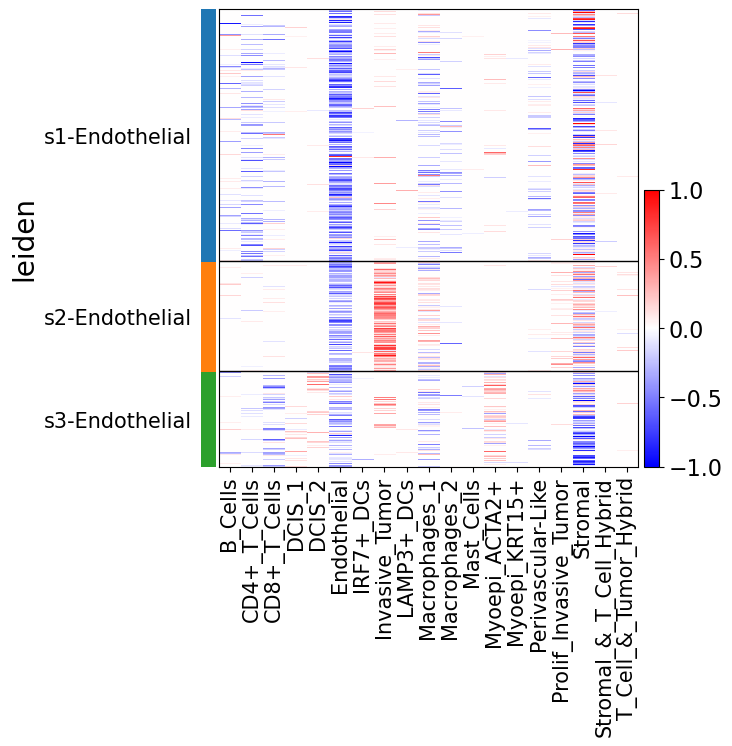

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()

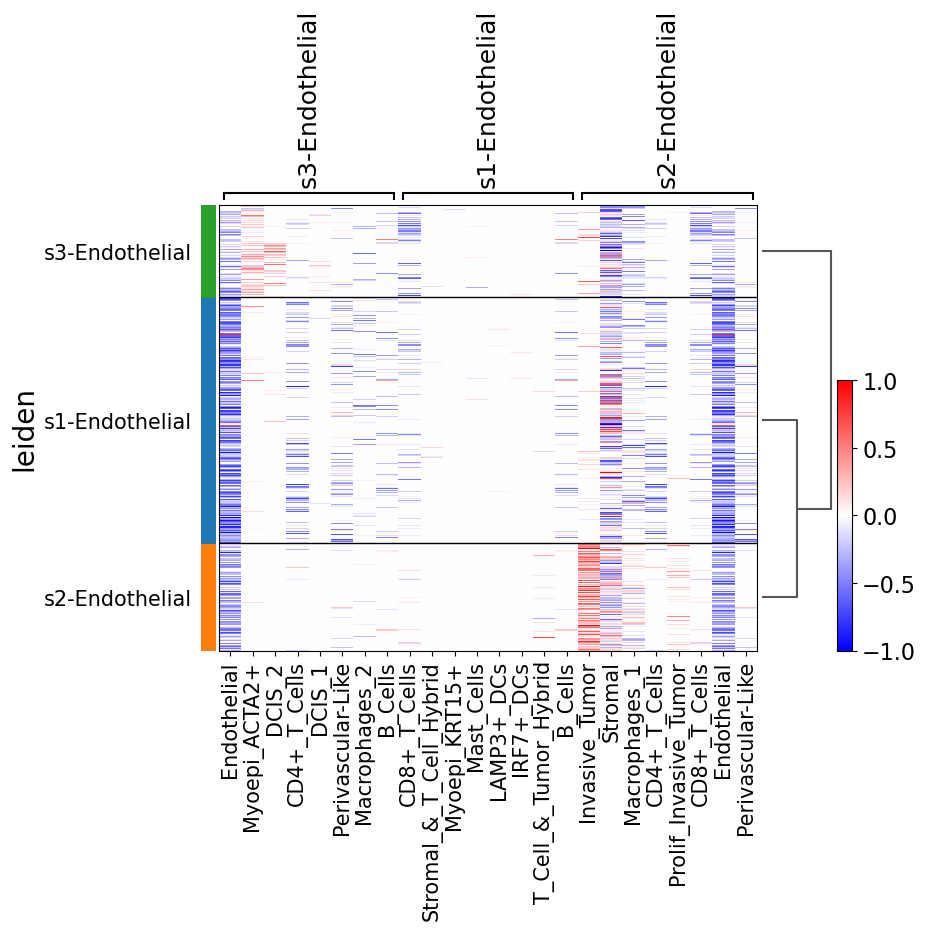

(['Invasive_Tumor', 'Prolif_Invasive_Tumor', 'T_Cell_&_Tumor_Hybrid'], [0.0, 1.5482285496271858e-45, 1.1724712966772148e-06])
(['Stromal', 'Macrophages_1', 'CD4+_T_Cells', 'CD8+_T_Cells', 'Endothelial', 'Perivascular-Like', 'Macrophages_2', 'B_Cells', 'DCIS_2', 'Myoepi_ACTA2+'], [2.5344867529887504e-110, 4.292679416633606e-102, 5.741211136459416e-59, 2.039043781890847e-37, 1.6308885456462232e-12, 1.911433142302639e-08, 5.942420510394252e-07, 0.0008832189458322439, 5.056192280467739e-07, 2.841118481175385e-14])


In [44]:
def select_CCI_genes(adata,gene):
    x=np.zeros((adata.shape[0],len(cell_types)))

    offset=genes.index(gene)
    for i in range(len(cell_types)):
        x[:,i]=x[:,i]+adata.X[:,i*len(genes)+offset]
    
    adata1=ad.AnnData(X=x, obs=adata.obs)
    adata1.var_names=cell_types
    return adata1
print(np.max(adata_type.X))
adata_gene=select_CCI_genes(adata_type,"KRT7")
#adata_gene=adata_gene[:,np.sum(adata_gene.X==0,axis=0)<=adata_gene.shape[0]*0.8]

print(np.max(adata_gene.X,axis=0),np.min(adata_gene.X,axis=0))

sc.pl.heatmap(adata_gene, var_names=adata_gene.var_names, groupby='leiden', cmap='bwr')

sc.tl.rank_genes_groups(adata_gene, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_gene, n_genes=8, show_gene_labels=True, cmap='bwr')

print(extract_genes_and_pvals_by_group(adata_gene,1,0.05,True))
print(extract_genes_and_pvals_by_group(adata_gene,1,0.05,False))